# CALIBRATION CONSTANT (Unit transformation  to erg/s/cm^2)

Observation values from the SDSS and Gaia Telescopes are with fluxes using the unprimed filters (u,g,r,i). But we need them to be standard values so eveyone in the world can recognise the values.

The standard observations uses the primed system (u',g',r',i'). We need the values to be Standard

#### What are data in Bicocca transimission filter file.
Filter Transmission column == Efficiency of the filter glass itself (where $1.000 = 100\%$ transparency)

QE X Filter shows the quantity of photons received by the detector.
Transmission(QE*Filter) column == $$\text{Filter Transmission} \times \text{Camera Sensor Efficiency (QE)} = \text{Total Data Captured}$$  


In [1]:
import astropy as astr
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import hist
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.visualization import simple_norm

# A&A specific settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], # A&A uses a Times-based font
    "axes.labelsize": 13,    # Standard size for A&A captions/labels
    "font.size": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "text.latex.preamble": r"\usepackage{txfonts}" # This matches the A&A math style
})
path_gaia = 'Bicocca-Tele.data/NGC6946_GAIA'
path_filter = 'Bicocca-Tele.data'
path_galaxy = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/LIGHT"
path_bias = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/BIAS"
path_dark = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/DARK"
path_flat = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/FLAT"


### CHOOSE FAINT STAR, OVER-SATURATED WILL GIVE WRONG MEASURES OF THE CALIBRATION CONSTANT.
* The telescope ability

In [2]:
with fits.open(path_gaia +"/GAIA3_2194501930600946944.fits") as hdu_gaia:
  flux = hdu_gaia[0].data
  wave_f = hdu_gaia[1].data


# === Step 1: Load filter and catalog flux ===
R_Band = Table.read(path_filter + "/R_Band_transmission_filter.txt", format="ascii")
G_Band = Table.read(path_filter + "/G_Band_transmission_filter.txt", format="ascii")
I_Band = Table.read(path_filter + "/I_Band_transmission_filter.txt", format="ascii")
    
wave_r = R_Band["Wavelength"]
trans_r = R_Band["TransmissionQEFilter"]
wave_g = G_Band["Wavelength"]
trans_g = G_Band["TransmissionQEFilter"]
wave_i = I_Band["Wavelength"]
trans_i = I_Band["TransmissionQEFilter"]

# flux and wave_f must come from GAIA catalog (already loaded)
flux_r_interp = np.interp(wave_r, wave_f, flux)
flux_g_interp = np.interp(wave_g, wave_f, flux)
flux_i_interp = np.interp(wave_i, wave_f, flux)

flux_r_band = flux_r_interp * trans_r
flux_g_band = flux_g_interp * trans_g
flux_i_band = flux_i_interp * trans_i

flux_star_r = np.trapezoid(flux_r_band, wave_r) / np.trapezoid(trans_r, wave_r) # The average flux normalized by the filter transmission \n
flux_star_g = np.trapezoid(flux_g_band, wave_g) / np.trapezoid(trans_g, wave_g) # Which is the actual value that we must get from the data in the sky subtraction file.
flux_star_i = np.trapezoid(flux_i_band, wave_i) / np.trapezoid(trans_i, wave_i) # They are used in the calibration constant part only.

print(flux_star_r)
print(flux_star_g)
print(flux_star_i)

1.9082867586901325e-14
1.8959358528132835e-14
1.5468983176691917e-14


In [5]:
hdu_gaia[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                  343                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

In [4]:
np.trapezoid(trans_r, wave_r)

np.float64(756.204868)

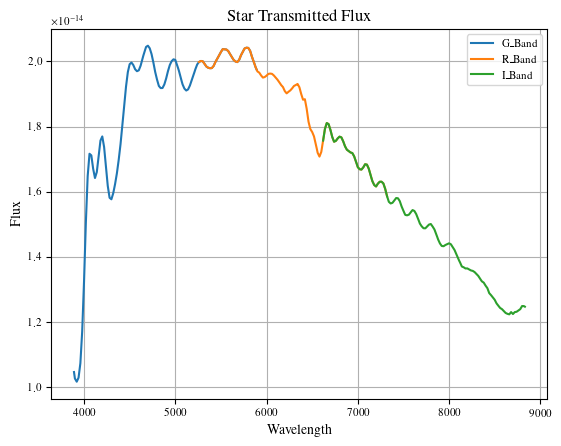

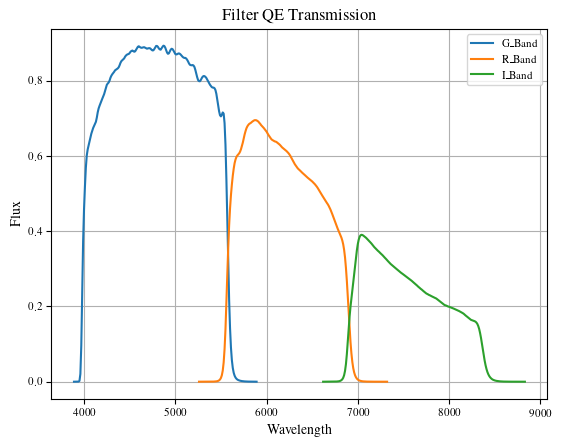

In [79]:
plt.plot(wave_g, (flux_g_interp), label="G_Band")
plt.plot(wave_r, (flux_r_interp), label="R_Band")
plt.plot(wave_i, (flux_i_interp), label="I_Band")
plt.ylabel('Flux')
plt.xlabel('Wavelength')
plt.title('Star Transmitted Flux')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(wave_g, (trans_g), label="G_Band")
plt.plot(wave_r, (trans_r), label="R_Band")
plt.plot(wave_i, (trans_i), label="I_Band")
plt.ylabel('Flux')
plt.xlabel('Wavelength')
plt.title('Filter QE Transmission')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# !pip install photutils # This must be downloaded on your device first.

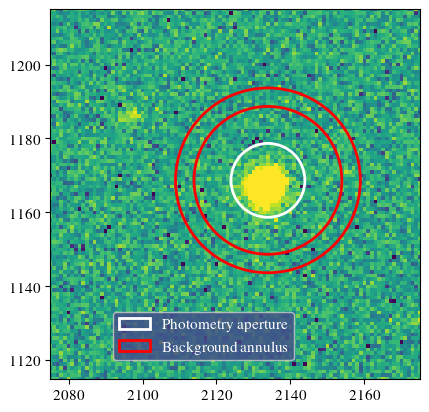

In [3]:
# === Step 2: Load image and measure instrumental flux ===
with fits.open(path_bias + "/master_bias.fits") as hdu_bias:
    master_bias = hdu_bias[0].data
with fits.open(path_dark + "/master_dark_300.fits") as hdu_dark:
    master_dark = hdu_dark[0].data
with fits.open(path_galaxy + "/2025-09-29_18-23-42_sci_NGC6946_G_exp300.00_0002.fits") as hdu_galaxy:
    # Everytime we change the galaxy image (filter), we need to change the position of the star from the ds9 and the master_flat. Be carful with the exposure time!
    image_data_galaxy = hdu_galaxy[0].data
with fits.open(path_flat +"/master_flat_G.fits") as hdu_flat:
    master_flat = hdu_flat[0].data

position_x , position_y = 2133.92 , 1168.67 # G band positions
# position_x , position_y = 2133.85 , 1165.35 # R band positions
# position_x , position_y = 2143.6 , 1185.8 # I band positions
    
# === Step 3: Plot the gaia stars ===

cleaned_image = ((image_data_galaxy - master_bias - (master_dark-master_bias))/ master_flat)*0.25/ 300
position = (position_x,position_y)    # target star position in pixels coordinates
aperture = CircularAperture(position, r=10)
annulus_aperture = CircularAnnulus(position, r_in=20, r_out=25)


norm = simple_norm(cleaned_image, 'sqrt', percent = 99)
plt.imshow(cleaned_image, norm=norm, interpolation='nearest')
plt.ylim(1115, 1215) 
plt.xlim(2075, 2175) 
# plt.xlabel('X Pixel') 
# plt.ylabel('Y Pixel')
ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor="#454D89", labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
# plt.title('Aperture and Annulus on Star')
plt.show()

## Why is sep.background not enough?
It averages values and produce a global map, not locally. So, we need to extract background in the for loop

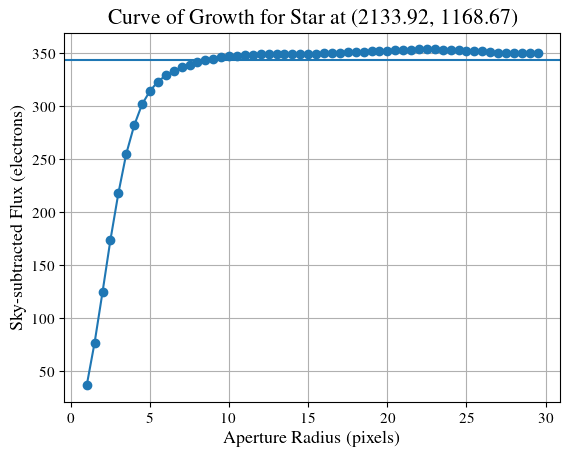

Instrumental flux at r = 12.0: 348.66 electrons
Physical flux in I band: 1.90e-14
Calibration constant: 5.44e-17 erg/s/cm²/e
Stored calibration constants in erg/s/cm²/e so you can use them in the next analysis:
      A- GAIA3_2194501930600946944.fits
       0- G band: 5.30e-17 
       1- G band: 5.38e-17
       2- G band: 5.33e-17
       0- R band: 5.50e-17 
       1- R band: 5.49e-17
       2- R band: 5.42e-17
       3- R band: 5.48e-17
       1- I band: 4.59e-17 
       2- I band: 4.64e-17
      B- GAIA3_2194501930600947008.fits
      


In [16]:
 # The curve of growth: the integrated light of the star grows with aperture until all the star’s flux is collected, revealing the PSF structure and the total stellar flux.
radii = np.arange(1, 30, 0.5)
fluxes = []
for r in radii:
    aperture = CircularAperture(position, r=r)
    annulus = annulus_aperture
    phot_table = aperture_photometry(cleaned_image, [aperture, annulus])
    aperture_sum = phot_table['aperture_sum_0'][0]
    annulus_sum = phot_table['aperture_sum_1'][0]
    bkg_per_pix = annulus_sum / annulus.area  
    total_bkg = bkg_per_pix * aperture.area
    net_flux = aperture_sum - total_bkg     # Extracting Noise and Background
    fluxes.append(net_flux)

# === Plot curve of growth ===
plt.plot(radii, fluxes, marker='o')
plt.xlabel("Aperture Radius (pixels)")
plt.ylabel("Sky-subtracted Flux (electrons)")
plt.axhline(fluxes[15])
plt.title("Curve of Growth for Star at {}".format(position))
plt.grid(True)
plt.show()


# === Step 4: Compute calibration constant ===
# Choose the radius where flux flattens (e.g., r = ??)
flatten_radius = 12.0 
chosen_index = np.where(radii == flatten_radius)[0][0]
instrumental_flux = fluxes[chosen_index]
calibration_constant = flux_star_g / instrumental_flux
# mag_star = ...  # known magnitude from catalog
# ZP = mag_star + 2.5 * np.log10(instrumental_flux) #Zero Point



# === Print results ===
print(f"Instrumental flux at r = {flatten_radius}: {instrumental_flux:.2f} electrons")
print(f"Physical flux in I band: {flux_star_g:.2e}")
print(f"Calibration constant: {calibration_constant:.2e} erg/s/cm²/e")
print("""Stored calibration constants in erg/s/cm²/e so you can use them in the next analysis:
      A- GAIA3_2194501930600946944.fits
       0- G band: 5.30e-17 
       1- G band: 5.38e-17
       2- G band: 5.33e-17
       0- R band: 5.50e-17 
       1- R band: 5.49e-17
       2- R band: 5.42e-17
       3- R band: 5.48e-17
       1- I band: 4.59e-17 
       2- I band: 4.64e-17
      B- GAIA3_2194501930600947008.fits
      """)

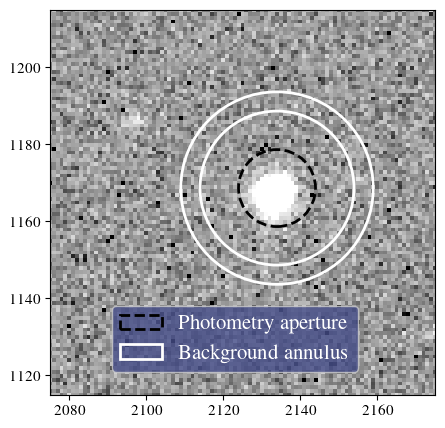

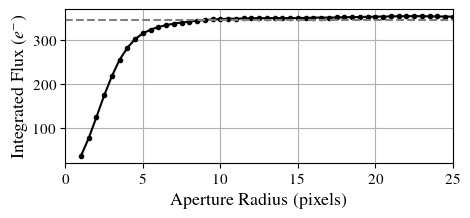

<Figure size 640x480 with 0 Axes>

In [23]:
position_x , position_y = 2133.92 , 1168.67 # G band positions
    
# === Step 3: Plot the gaia stars ===

cleaned_image = ((image_data_galaxy - master_bias - (master_dark-master_bias))/ master_flat)*0.25/ 300
position = (position_x,position_y)    # target star position in pixels coordinates
aperture = CircularAperture(position, r=10)
annulus_aperture = CircularAnnulus(position, r_in=20, r_out=25)

fig , ax = plt.subplots(figsize = (5,5))
ax.imshow(cleaned_image, norm=norm, interpolation='nearest', cmap = 'grey')
ax.set_ylim(1115, 1215) 
ax.set_xlim(2075, 2175) 
# ax.set_xticks([])
# ax.set_yticks([])
ap_patches = aperture.plot(color='black', linestyle = '--', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='white', linestyle = '-', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.16, 0.06), facecolor="#454D89", labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 15})

plt.show()

fig , ax = plt.subplots(figsize = (5,2))
ax.plot(radii, fluxes, marker='.', color = 'black')
ax.set_xlabel("Aperture Radius (pixels)")
ax.set_ylabel("Integrated Flux ($e^-$) ")
ax.set_xlim(0,25)
ax.axhline(fluxes[16], color = 'grey', linestyle = '--')
# plt.title("Curve of Growth")
plt.grid(True)
plt.show()

plt.tight_layout()
plt.show()

In [75]:
calib_const = {
    "G": {
        "00": 5.30e-17,
        "01": 5.38e-17,
        "02": 5.33e-17
    },
    "R": {
        "00": 5.50e-17,
        "01": 5.49e-17,
        "02": 5.42e-17,
        "03": 5.48e-17
    },
    "I": {
        "01": 4.59e-17,
        "02": 4.64e-17   
    }
}


g_mean = (calib_const["G"]["00"] + calib_const["G"]["01"] + calib_const["G"]["02"])/3
r_mean = (calib_const["R"]["00"] + calib_const["R"]["01"] + calib_const["R"]["02"] + calib_const["R"]["03"])/4
i_mean = (calib_const["I"]["01"] + calib_const["I"]["02"])/2
print(g_mean, r_mean)

5.336666666666667e-17 5.4725e-17
